In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from utils import *

In [3]:
data = ImageDataBunch.from_folder('data', valid='valid.cropped', test='test.cropped', train='train.cropped', 
                                  bs=96, size=(256,512), ds_tfms=get_transforms(do_flip=False),
                                  resize_method=ResizeMethod.SQUISH).normalize(imagenet_stats)

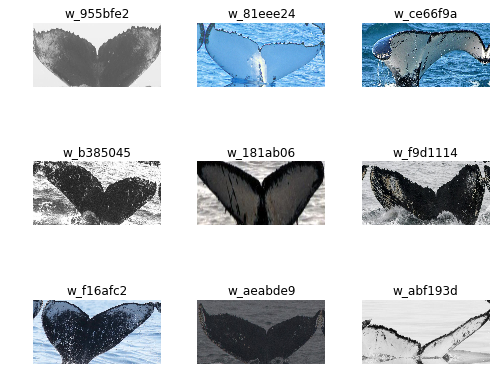

In [4]:
data.show_batch(rows=3, figsize=(7,6))

In [5]:
learn = create_cnn(data, models.resnet50, metrics=[accuracy, map5]).to_fp16()
learn.model = torch.nn.DataParallel(learn.model)
learn.clip_grad();

In [6]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


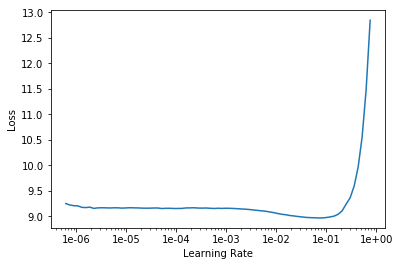

In [7]:
learn.recorder.plot()

In [8]:
max_lr = 1e-01
lrs = [max_lr/100, max_lr/10, max_lr]

In [9]:
learn.fit_one_cycle(9, lrs)

epoch,train_loss,valid_loss,accuracy,map5
1,3.853229,6.516507,0.105863,0.141314
2,6.302186,9.763702,0.096906,0.127674
3,9.901172,16.313271,0.142915,0.187106
4,8.284508,14.888761,0.283388,0.352898
5,5.163355,10.562034,0.410831,0.479805
6,2.343244,6.637746,0.547231,0.613572
7,0.821134,6.798445,0.659609,0.710539
8,0.248276,16.906134,0.721498,0.767230
9,0.127310,2.464267,0.740635,0.786754


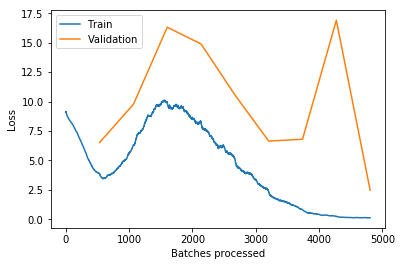

In [10]:
learn.recorder.plot_losses()

In [11]:
learn.save('resnet-with-weights-prefreeze')

In [12]:
learn.unfreeze()

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


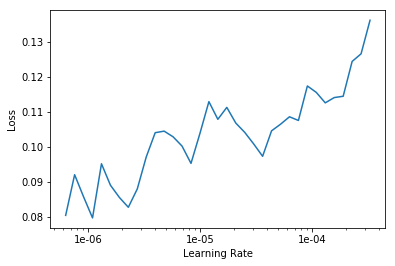

In [14]:
learn.recorder.plot()

In [15]:
max_lr = 1e-06
lrs = [max_lr/100, max_lr/10, max_lr]

In [16]:
learn.fit_one_cycle(3, lrs)

epoch,train_loss,valid_loss,accuracy,map5
1,9.788371,39.689087,0.038681,0.057736
2,3.922293,nan,0.382329,0.450088
3,0.574851,3.119978,0.667752,0.722496


In [17]:
learn.save('resnet-with-weights-postfreeze')
preds, _ = learn.get_preds(DatasetType.Test)
preds = torch.cat((preds, torch.ones_like(preds[:, :1])), 1)

In [19]:
classes = learn.data.classes + ['new_whale']

In [ ]:
create_submission(preds, learn.data, 'resnet-with-weights', classes)